# Homotopic optimal control of interplanetary spacecraft

## Dynamics

In [21]:
from sympy import *
init_printing()

In [22]:
# state variables
x, y, z, vx, vy, vz = symbols('x y z v_x v_y v_z', real=True)
m = symbols('m', real=True, nonnegative=True)

# position
p = Matrix([x, y, z])

# velocity
v = Matrix([vx, vy, vz])

# state
s = Matrix([p, v, [m]])
s.T

[x  y  z  vₓ  v_y  v_z  m]

In [23]:
# control parameters
um = symbols('u', real=True, positive=True)
ux, uy, uz =symbols('\\hat{u}_x \\hat{u}_y \\hat{u}_z', real=True)
uh = Matrix([ux, uy, uz])
u = Matrix([[um], uh])

# constants
c1, c2, mu = symbols('c_1 c_2 \\mu', real=True, positive=True)

# equations of motion
ds = Matrix([
    v,
    (-mu/((x**2 + y**2 + z**2)**(Rational(3/2))))*(p) + (c1*um/m)*uh,
    [-c2*um]
])
ds

⎡                vₓ                ⎤
⎢                                  ⎥
⎢               v_y                ⎥
⎢                                  ⎥
⎢               v_z                ⎥
⎢                                  ⎥
⎢\hat{u}ₓ⋅c₁⋅u         \mu⋅x       ⎥
⎢───────────── - ───────────────── ⎥
⎢      m                       3/2 ⎥
⎢                ⎛ 2    2    2⎞    ⎥
⎢                ⎝x  + y  + z ⎠    ⎥
⎢                                  ⎥
⎢\hat{u}_y⋅c₁⋅u         \mu⋅y      ⎥
⎢────────────── - ─────────────────⎥
⎢      m                        3/2⎥
⎢                 ⎛ 2    2    2⎞   ⎥
⎢                 ⎝x  + y  + z ⎠   ⎥
⎢                                  ⎥
⎢\hat{u}_z⋅c₁⋅u         \mu⋅z      ⎥
⎢────────────── - ─────────────────⎥
⎢      m                        3/2⎥
⎢                 ⎛ 2    2    2⎞   ⎥
⎢                 ⎝x  + y  + z ⎠   ⎥
⎢                                  ⎥
⎣              -c₂⋅u               ⎦

In [24]:
# homotopy parameter
alpha, beta = symbols('\\alpha \\beta', real=True, nonnegative=True)

# Lagrangian
L = alpha + (1-alpha)*um
L = beta*L + (1-beta)*um**2
L

In [25]:
 # costate variables
l = Matrix(symbols(['\\lambda_{' + str(var) + '}' for var in s]), real=True)
l.T

[\lambda_{x}  \lambda_{y}  \lambda_{z}  \lambda_{v_x}  \lambda_{v_y}  \lambda_
{v_z}  \lambda_{m}]

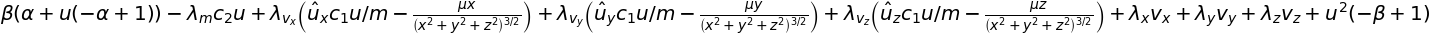

In [26]:
# Hamiltonian
H = l.dot(ds) + L
H

In [27]:
# minimise Hamiltonian w.r.t. controls
lv = Matrix(l[3:6])
uhs = -lv/sqrt(sum([var**2 for var in lv]))
uhs

⎡                   -\lambda_{v_x}                    ⎤
⎢─────────────────────────────────────────────────────⎥
⎢   __________________________________________________⎥
⎢  ╱              2                2                2 ⎥
⎢╲╱  \lambda_{v_x}  + \lambda_{v_y}  + \lambda_{v_z}  ⎥
⎢                                                     ⎥
⎢                   -\lambda_{v_y}                    ⎥
⎢─────────────────────────────────────────────────────⎥
⎢   __________________________________________________⎥
⎢  ╱              2                2                2 ⎥
⎢╲╱  \lambda_{v_x}  + \lambda_{v_y}  + \lambda_{v_z}  ⎥
⎢                                                     ⎥
⎢                   -\lambda_{v_z}                    ⎥
⎢─────────────────────────────────────────────────────⎥
⎢   __________________________________________________⎥
⎢  ╱              2                2                2 ⎥
⎣╲╱  \lambda_{v_x}  + \lambda_{v_y}  + \lambda_{v_z}  ⎦

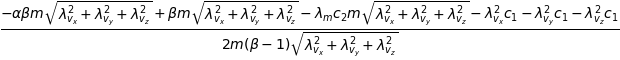

In [28]:
# new Hamiltonian
H1 = H.subs(ux, uhs[0]).subs(uy, uhs[1]).subs(uz, uhs[2])
ums = solve(H1.diff(um), um)[0]
ums

In [29]:
us = Matrix([[ums], uhs])
us

⎡                    __________________________________________________       
⎢                   ╱              2                2                2        
⎢- \alpha⋅\beta⋅m⋅╲╱  \lambda_{v_x}  + \lambda_{v_y}  + \lambda_{v_z}   + \bet
⎢─────────────────────────────────────────────────────────────────────────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [30]:
# costate equations of motion
dl = -H.diff(s)
dl

⎡                ⎛            2                        ⎞                      
⎢                ⎜     3⋅\mu⋅x               \mu       ⎟   3⋅\lambda_{v_y}⋅\mu
⎢- \lambda_{v_x}⋅⎜───────────────── - ─────────────────⎟ - ───────────────────
⎢                ⎜              5/2                 3/2⎟                    5/
⎢                ⎜⎛ 2    2    2⎞      ⎛ 2    2    2⎞   ⎟      ⎛ 2    2    2⎞  
⎢                ⎝⎝x  + y  + z ⎠      ⎝x  + y  + z ⎠   ⎠      ⎝x  + y  + z ⎠  
⎢                                                                             
⎢                                          ⎛            2                     
⎢  3⋅\lambda_{v_x}⋅\mu⋅x⋅y                 ⎜     3⋅\mu⋅y               \mu    
⎢- ─────────────────────── - \lambda_{v_y}⋅⎜───────────────── - ──────────────
⎢                   5/2                    ⎜              5/2                 
⎢     ⎛ 2    2    2⎞                       ⎜⎛ 2    2    2⎞      ⎛ 2    2    2⎞
⎢     ⎝x  + y  + z ⎠                       ⎝⎝x  + y 

In [ ]:
Matrix([
    ums.subs(alpha, 0).subs(beta, 0),
    ums.subs(alpha, 0).subs(beta, 1),
    ums.subs(alpha, 1).subs(beta, 0),
    ums.subs(alpha, 1).subs(beta, 1),
    ums.subs(alpha, 0),
    ums.subs(alpha, 1),
    ums.subs(beta, 0),
    ums.subs(beta, 1),
    ums
])

In [32]:
L.subs(beta, 1).subs(alpha, 1)

## Base trajectory

In [12]:
import sys, numpy as np, matplotlib.pyplot as plt, pygmo as pg, pykep as pk
sys.path.append('../src/')
from spacecraft import Spacecraft
from indirect import Indirect
%matplotlib

Using matplotlib backend: TkAgg


In [2]:
# instantiate problem
seg = Spacecraft(T=0.2, isp=2500, m=1000)

In [3]:
# initial state
s0 = np.hstack((*pk.planet.jpl_lp('earth').eph(pk.epoch(0)), seg.M))

# duration bounds in days
Tlb = 100
Tub = 500

# costates bounds
lb = 50

# homotopy parameters
alpha = 1
seg.beta = 0

In [4]:
# solve for base trajectory
zl, fl, feasl = seg.solve_par(s0, alpha, 200, 450, 50, npar=1000)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


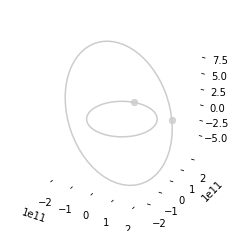

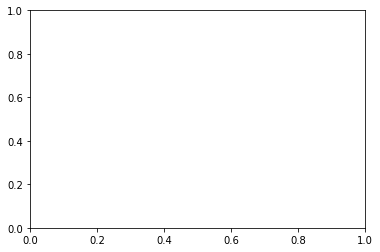

In [6]:
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig1, ax1 = plt.subplots(1)

# orbits
pk.orbit_plots.plot_planet(
    pk.planet.jpl_lp('earth'), pk.epoch(6939.5), color=(0.8, 0.8, 0.8), ax=ax)
pk.orbit_plots.plot_planet(
    pk.planet.jpl_lp('mars'), pk.epoch(6939.5), color=(0.8, 0.8, 0.8), ax=ax)

# trajectories
for i, z in enumerate(zl):
    
    if feasl[i]:
        
        # simulate
        tl, sl, ul = seg.propagate(z[0], s0, z[2:], 0, u=True)

        # plot trajectory
        ax.plot(sl[:,0], sl[:,1], sl[:,2], "k-", alpha=0.5)

        ax1.plot(tl, ul[:,0], "k-", alpha=0.1)

# tidy up
ax.set_aspect('equal')
ax.grid('False')

# Get rid of the panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

plt.show()

# Policy homotopy in $\beta \times [0, 1] : \alpha = 0$

In [18]:
# best decision vector
zs = [379.20912013,   0.93398202,  12.76567896, -45.55493263,  -8.26940351, 49.99989562, 3.00127225, -8.58992837, 8.32972382]

# best homotopy parameter
betas = 0

# current homotopy parameter
seg.beta = betas

# constant alpha parameter
alpha = 1

# solution
sols = list()

# homotopy loop
i = 0
while i < 2:
    
    print('Solving at {:1f}, {}'.format(seg.beta, z))
    
    # solve
    z, f, feas = seg.solve(s0, alpha, 100, zs[0], 1000, z=zs)
    
    # if succesfull
    if feas:
        
        # best decision vector
        zs = z
        
        # best homotopy parameter
        betas = seg.beta
        
        # record solution
        sols.append((zs, betas))
        
        # finished homotopy
        if seg.beta == 1:
            print('Finished')
            break
            
        # homotopy boundry
        elif seg.beta > 0.99:
            seg.beta = 1
            i += 1
            
        # increase parameter
        else:
            
            # bounded step
            bstep = min(0.1, (1 + seg.beta)/2. - seg.beta)
            
            # apply step
            seg.beta += bstep
            
    # failure
    else:
        
        # decrease parameter
        seg.beta = (betas + seg.beta)/2.

Solving at 0.000000, [ 3.66653231e+02  7.40902475e-01  1.42343110e+01 -4.34141166e+01
 -8.59675197e+00  4.83509509e+01  4.13066530e-02 -9.08458499e+00
  6.76564309e+00]
Solving at 0.100000, [379.20912013   0.93398202  12.76567896 -45.55493263  -8.26940351
  49.99989562   3.00127225  -8.58992837   8.32972382]
Solving at 0.200000, [376.07178809   0.88636469  13.50510273 -44.65912524  -7.68863096
  49.58162605   1.76240249  -7.79936473   7.71769351]
Solving at 0.300000, [373.3730887    0.8447901   14.2300129  -43.96137574  -7.05043982
  49.31721231   0.5880371   -6.98175536   7.12604846]
Solving at 0.400000, [370.97419662   0.80724101  14.91989833 -43.39411048  -6.35946341
  49.1324275   -0.5194005   -6.12778182   6.55214929]
Solving at 0.500000, [368.78116672   0.77233707  15.56535532 -42.92708372  -5.62256127
  48.99544795  -1.5576188   -5.23763467   5.99608218]
Solving at 0.600000, [366.73092558   0.73911517  16.15243173 -42.53139167  -4.84813317
  48.87368421  -2.51922981  -4.31768725

In [20]:
#np.save('spacecraft_z_beta_homotopy_alpha_0.npy', np.array(sols))
#np.save('spacecraft_z_beta_homotopy_alpha_1.npy', np.array(sols))

In [ ]:
sols = np.load('spacecraft_z_beta_homotopy_alpha_1.npy'); alpha = 1
#sols = np.load('spacecraft_z_beta_homotopy_alpha_0.npy'); alpha = 0

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

fig1, ax1 = plt.subplots(1)

# orbits
pk.orbit_plots.plot_planet(
    pk.planet.jpl_lp('earth'), pk.epoch(0), color=(0.8, 0.8, 0.8), ax=ax)
pk.orbit_plots.plot_planet(
    pk.planet.jpl_lp('mars'), pk.epoch(0), color=(0.8, 0.8, 0.8), ax=ax, s=0)


for i, sol in enumerate(sols):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    seg.beta = sol[1]
    
    # simulate
    tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax.plot(sl[:,0], sl[:,1], sl[:,2], "k-", label=r'$\alpha = {}, \beta=0$'.format(alpha))
        ax1.plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=0$'.format(alpha))
    elif i == len(sols) - 1:
        ax.plot(sl[:,0], sl[:,1], sl[:,2], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
        ax1.plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:   
        ax.plot(sl[:,0], sl[:,1], sl[:,2], "k-", alpha=0.1)
        ax1.plot(tl, ul[:,0], "k-", alpha=0.1)
    

# tidy up
ax.set_aspect('equal')
ax.grid('False')

# Get rid of the panes
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# Get rid of the spines
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'$u$')
ax1.set_ylim(-0.05, 1.05)


ax.legend()
ax1.legend()
fig.tight_layout()
#fig.savefig('spacecraft_s_beta_homotopy_alpha_0.pdf', bbox_inches='tight')
#fig1.savefig('spacecraft_u_beta_homotopy_alpha_0.pdf', bbox_inches='tight')
fig.savefig('spacecraft_s_beta_homotopy_alpha_{}.pdf'.format(alpha), bbox_inches='tight')
fig1.savefig('spacecraft_u_beta_homotopy_alpha_{}.pdf'.format(alpha), bbox_inches='tight')

plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


In [38]:
# homotopy data
sols1 = np.load('spacecraft_z_beta_homotopy_alpha_1.npy')
sols0 = np.load('spacecraft_z_beta_homotopy_alpha_0.npy')

# figure
fig, ax = plt.subplots(2, sharex=True)

alpha = 0
for i, sol in enumerate(sols0):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    seg.beta = sol[1]
    
    # simulate
    tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax[alpha].plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=0$'.format(alpha))
    elif i == len(sols) - 1:
        ax[alpha].plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:
        ax[alpha].plot(tl, ul[:,0], "k-", alpha=0.1)
    
alpha = 1
for i, sol in enumerate(sols1):
    
    # decision vector
    z = sol[0]
    
    # beta homotopy parameter
    seg.beta = sol[1]
    
    # simulate
    tl, sl, ul = seg.propagate(z[0], s0, z[2:], alpha, u=True)
    
    # plot trajectory
    if i == 0:
        ax[alpha].plot(tl, ul[:,0], "k-", label=r'$\alpha = {}, \beta=0$'.format(alpha))
    elif i == len(sols) - 1:
        ax[alpha].plot(tl, ul[:,0], "k--", label=r'$\alpha = {}, \beta=1$'.format(alpha))
    else:
        ax[alpha].plot(tl, ul[:,0], "k-", alpha=0.1)
    

ax[1].set_xlabel(r'$t$')
ax[0].set_ylabel(r'$u$')
ax[1].set_ylabel(r'$u$')
ax[0].legend()
ax[1].legend()
ax[0].set_ylim(-0.05, 1.05)
ax[1].set_ylim(-0.05, 1.05)
plt.show()

## Policy homotopy $\alpha \times [0, 1] : \beta = 1$